In [26]:
from pathlib import Path
import re
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import math

In [27]:
def load_texts(local_Illiad: str = '../data/Homer_Illiad.txt',
               local_Odyssey: str = '../data/Homer_Odyssey.txt',):
    """Load Wonderland and Looking-Glass texts from disk.

    Parameters
    ----------
    local_Illiad : str
        Path to Illiad text file. Defaults to '../data/Homer_Illiad.txt'.
    local_Odyssey : str
        Path to Odyssey text file. Defaults to '../data/Homer_Odyssey.txt'.

    Returns
    -------
    tuple[str, str]
        (illiad_text, odyssey_text).

    Raises
    ------
    FileNotFoundError
        If either file is missing.

    Extra Notes
    -----------
    - Using UTF-8 with `errors='ignore'` avoids codec exceptions on
      older Project Gutenberg dumps or inconsistent encodings.
    """
    p1, p2 = Path(local_Illiad), Path(local_Odyssey)

    # Fail fast with a clear message if a file is missing
    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please place 'Homer_Illiad.txt' at this path or update load_texts(...)."
        )
    if not p2.exists():
        raise FileNotFoundError(
            f"Missing file: {p2}\n"
            "→ Please place 'Homer_Odyssey.txt' at this path or update load_texts(...)."
        )

    # Read the files (UTF-8; ignore undecodable bytes to stay robust)
    illiad   = p1.read_text(encoding='utf-8', errors='ignore')
    odyssey = p2.read_text(encoding='utf-8', errors='ignore')
    return illiad, odyssey

In [28]:
def normalize(text: str) -> str:
    """Normalize a Gutenberg-like text for tokenization.

    Steps
    -----
    1) Heuristically strip Project Gutenberg headers/footers if present
       (looks for *** START ... *** END markers).
    2) Normalize newlines to '\n'.

    Parameters
    ----------
    text : str
        Raw text as loaded from disk (can be empty).

    Returns
    -------
    str
        Cleaned text suitable for tokenization and counting.
    """
    if not text:
        return ''
    # Clip to the main body if markers are present.
    start = text.find('----------------------------------------------------------------------')
    end   = text.find('THE END')
    if start != -1 and end != -1 and end > start:
        text = text[start:end]
    # Normalize Windows line endings.
    return text.replace('\r\n', '\n')


# -------- Tokenization helpers (simple) --------

WORD_RE = re.compile(r"[A-Za-z']+")  # keep apostrophes in words (e.g., don't -> don't)

def words(text: str):
    """Simple word tokenizer (lowercased, ASCII letters + apostrophes).

    Pros
    ----
    - Very fast and dependency-free.
    - Good enough for frequency/keyness demonstrations.

    Cons
    ----
    - No punctuation words, no sentence boundaries, no POS tags.
    - May treat possessives inconsistently across sources.

    Returns
    -------
    list[str]
        Lowercased word words.
    """
    return WORD_RE.findall(text.lower())

def loadActionWords(local_actionWords: str = '../data/actionWords.txt',):

    p1 = Path(local_actionWords)


    if not p1.exists():
        raise FileNotFoundError(
            f"Missing file: {p1}\n"
            "→ Please place 'actionWords.txt' at this path or update load_texts(...)."
        )

    actionWords = p1.read_text(encoding='utf-8', errors='ignore')
    actionWords_normalized = normalize(actionWords)
    actionWords_words = words(actionWords_normalized)
    actionWords_hashmap = {word: 0 for word in actionWords_words}
    return actionWords_hashmap

In [29]:
# Load raw texts (forgiving: returns '' if a file is missing)
illiad_raw, odyssey_raw = load_texts()

# Normalize for tokenization
illiad   = normalize(illiad_raw)
odyssey = normalize(odyssey_raw)

illiad_hash = loadActionWords()
odyssey_hash = loadActionWords()
print(f"Illiad chars: {len(illiad):,} | Odyssey chars: {len(odyssey):,}")

Illiad chars: 806,696 | Odyssey chars: 609,765


In [30]:
illiad_words = words(illiad)
odyssey_words = words(odyssey)

# filling the hashmap of illiad
for word in illiad_words:
    if word in illiad_hash:
        illiad_hash[word] += 1

# filling the hashmap of odyssey
for word in odyssey_words:
    if word in odyssey_hash:
        odyssey_hash[word] += 1

# printing the illiad hash
print("illiad words:")
for word, value in illiad_hash.items():
    if value > 0:
        print(word, value)

print("odyssey words:")
# printing the odyssey hash
for word, value in odyssey_hash.items():
    if value > 0:
        print(word, value)


illiad words:
slew 31
slain 62
slay 23
slaughter 7
smote 22
smite 3
smitten 2
pierced 23
pierce 11
wounded 57
wound 51
struck 153
strike 12
stricken 13
killed 137
kill 59
fell 184
perished 12
perish 23
destroyed 4
destroy 13
spear 385
speared 11
thrust 14
sword 66
arrow 74
shot 13
shoot 4
hurled 24
hurl 8
cast 15
aimed 31
brandished 5
brandish 1
wielded 4
wield 7
fought 50
fight 335
fighting 145
battled 1
battle 241
war 75
attacked 10
attack 38
assailed 1
assail 3
charged 9
charge 33
rushed 15
stormed 1
storm 15
raged 12
rage 30
fury 51
furious 26
wrath 1
anger 64
angered 10
vengeance 2
avenge 16
pursued 4
pursue 10
chase 22
fled 26
flight 32
mighty 113
valiant 47
valorous 1
prowess 15
conquer 1
vanquished 14
vanquish 6
subdue 1
overcame 1
overcome 13
foe 24
enemy 14
combat 26
strife 8
conflict 1
carnage 2
defended 3
defend 28
resisted 1
withstood 2
withstand 6
repel 1
gore 8
corpse 3
doom 23
doomed 8
odyssey words:
slew 1
slain 2
slay 2
slaughter 2
smote 8
smite 2
pierced 2
pierce 3
w

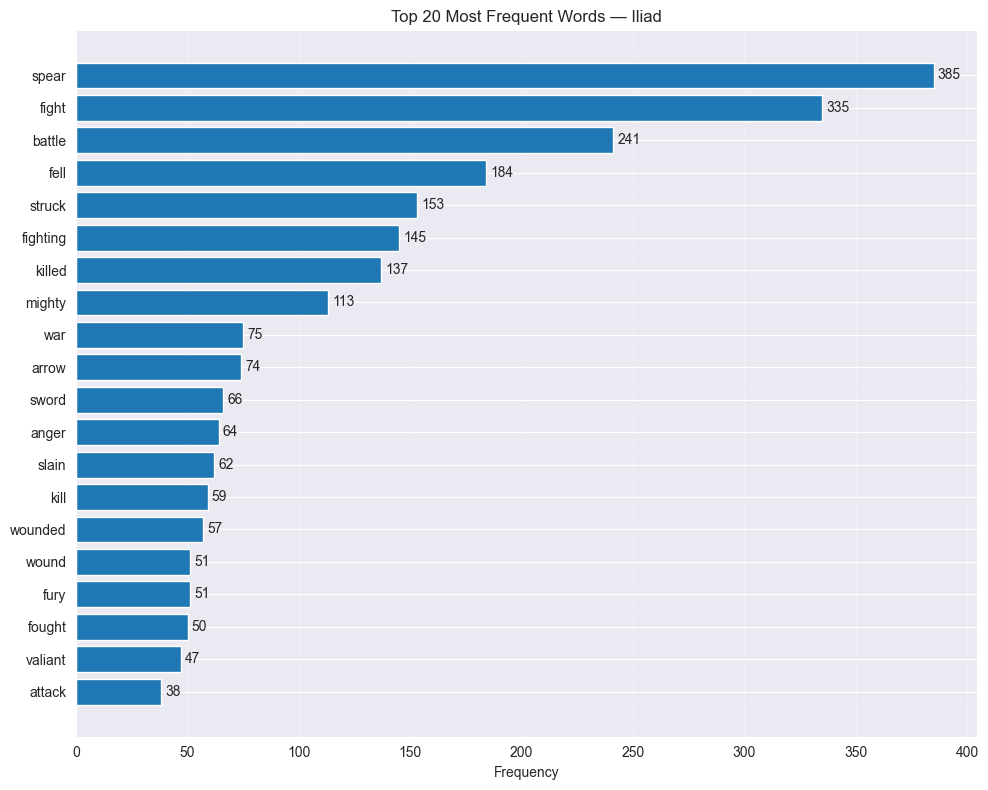

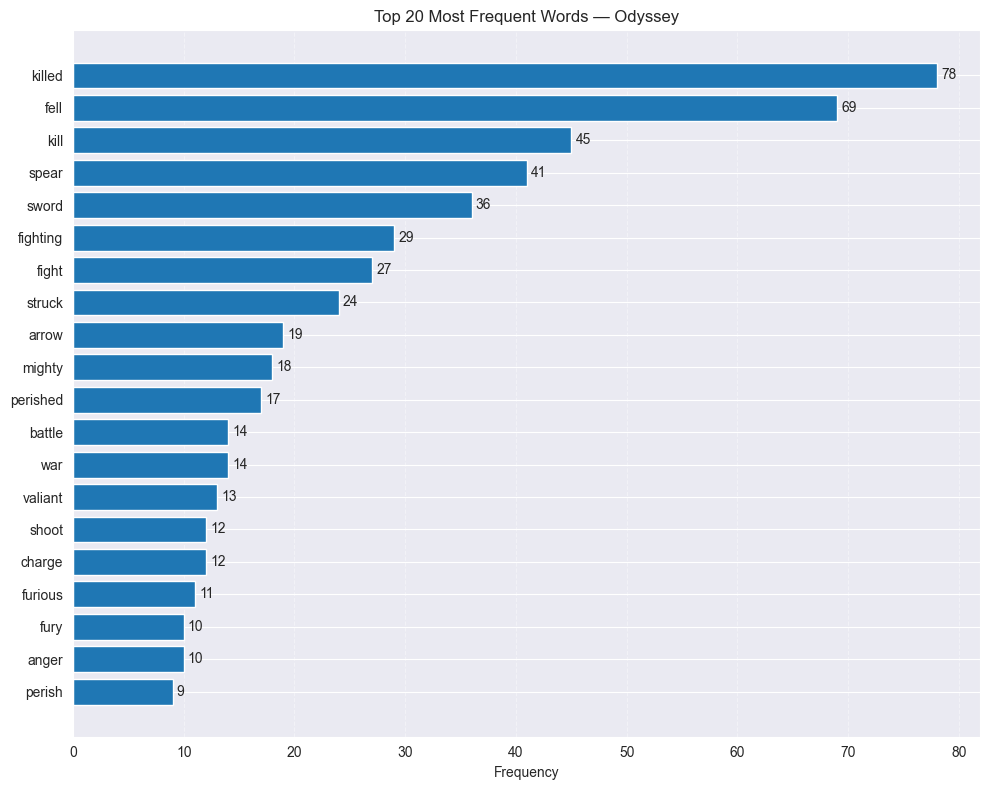

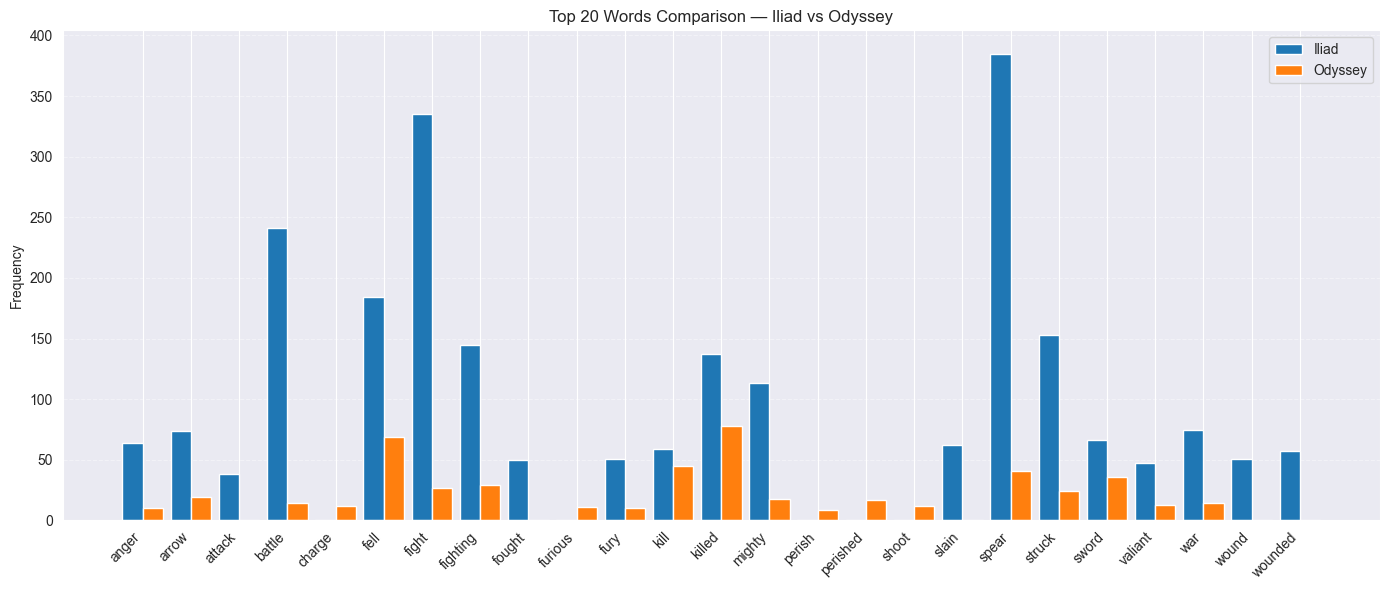

Total word count in Iliad:   3212
Total word count in Odyssey: 661


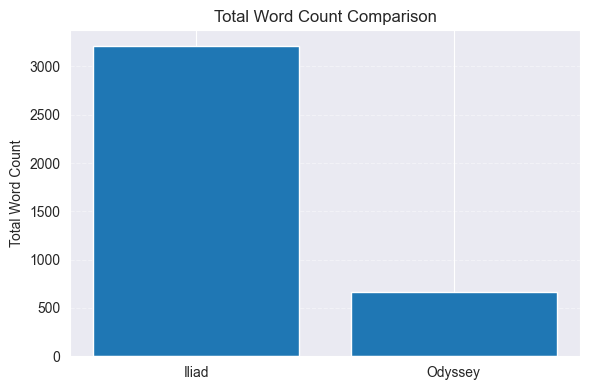

In [31]:
# ---------- Helpers ----------
def to_int(v):
    try:
        return int(v)
    except (TypeError, ValueError):
        return 0

def top_n(d: dict, n: int = 20):
    return dict(sorted(((k, to_int(v)) for k, v in d.items()),
                       key=lambda x: x[1], reverse=True)[:n])

# ---------- Compute top-20 ----------
illiad_top20  = top_n(illiad_hash, 20)
odyssey_top20 = top_n(odyssey_hash, 20)

# ---------- Individual charts (horizontal for readability) ----------
def plot_horizontal(data_dict, title):
    keys = list(data_dict.keys())
    vals = list(data_dict.values())
    order = sorted(range(len(vals)), key=lambda i: vals[i], reverse=True)
    keys = [keys[i] for i in order]
    vals = [vals[i] for i in order]

    plt.figure(figsize=(10, 8))
    bars = plt.barh(keys, vals)
    plt.xlabel("Frequency")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.gca().bar_label(bars, fmt="%d", padding=3)

plot_horizontal(illiad_top20,  "Top 20 Most Frequent Words — Iliad")
plt.savefig("../results/tables/AW_Top 20 Most Frequent Words — Iliad.png", dpi=300, bbox_inches="tight")
plot_horizontal(odyssey_top20, "Top 20 Most Frequent Words — Odyssey")
plt.savefig("../results/tables/AW_Top 20 Most Frequent Words — Odyssey.png", dpi=300, bbox_inches="tight")

# ---------- Combined grouped comparison ----------
all_words = sorted(set(illiad_top20.keys()) | set(odyssey_top20.keys()))
illiad_vals  = [illiad_top20.get(w, 0) for w in all_words]
odyssey_vals = [odyssey_top20.get(w, 0) for w in all_words]

x = range(len(all_words))
width = 0.42

plt.figure(figsize=(14, 6))
plt.bar([i - width/2 for i in x], illiad_vals,  width=width, label="Iliad")
plt.bar([i + width/2 for i in x], odyssey_vals, width=width, label="Odyssey")
plt.xticks(list(x), all_words, rotation=45, ha="right")
plt.ylabel("Frequency")
plt.title("Top 20 Words Comparison — Iliad vs Odyssey")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.savefig("../results/figures/AW_Most_frequent_words.png", dpi=300, bbox_inches="tight")
plt.show()

# ---------- NEW: Compare Total Word Counts ----------
total_illiad  = sum(to_int(v) for v in illiad_hash.values())
total_odyssey = sum(to_int(v) for v in odyssey_hash.values())

print("Total word count in Iliad:  ", total_illiad)
print("Total word count in Odyssey:", total_odyssey)

# Plot total comparison
plt.figure(figsize=(6, 4))
plt.bar(["Iliad", "Odyssey"], [total_illiad, total_odyssey])
plt.ylabel("Total Word Count")
plt.title("Total Word Count Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("../results/figures/AW_Total_words_count_comparison.png", dpi=300, bbox_inches="tight")
plt.show()